In [2]:
import pandas as pd
import numpy as np
import xgboost as xgb
from math import sqrt
from math import acos
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from tqdm import tqdm
from collections import defaultdict


In [3]:
def load_data(vector_filename, ion_type):
    # Read file
    if vector_filename.split(".")[-1] == "pkl":
        vectors = pd.read_pickle(vector_filename)
    elif vector_filename.split(".")[-1] == "h5":
        # vectors = pd.read_hdf(vector_filename, key='table', stop=1000)
        vectors = pd.read_hdf(vector_filename, key="table")
    else:
        print("Unsuported feature vector format")
        exit(1)

    # Extract targets for given ion type
    target_names = list(vectors.columns[vectors.columns.str.contains("targets")])
    if not "targets_{}".format(ion_type) in target_names:
        print("Targets for {} could not be found in vector file.".format(ion_type))
        print("Vector file only contains these targets: {}".format(target_names))
        exit(1)

    targets = vectors.pop("targets_{}".format(ion_type))
    target_names.remove("targets_{}".format(ion_type))
    for n in target_names:
        vectors.pop(n)

    # Get psmids
    psmids = vectors.pop("psmid")

    return (vectors, targets, psmids)

In [4]:
def ms2pip_pearson(true, pred):
    """
    Return pearson of tic-normalized, log-transformed intensities, 
    the MS2PIP way.
    """
    #tic_norm = lambda x: x / np.sum(x)
    # log_transform = lambda x: np.log2(x + 0.001)
    corr = pearsonr(
        true, 
        pred
    )[0]
    return (corr)

In [5]:
def spectral_angle(true, pred, epsilon=1e-7):
    """
    Return square root normalized spectral angle.
    See https://doi.org/10.1074/mcp.O113.036475
    """
    
    de_log = lambda x: (2**x)-0.001
    l2_normalize = lambda x: x / sqrt(max(sum(x**2), epsilon))

    true = np.array(true)
    pred = np.array(pred)
    
    pred_norm = l2_normalize(de_log(pred))
    true_norm = l2_normalize(de_log(true))
    
    spectral_angle = 1 - (2 * acos(np.dot(pred_norm, true_norm)) / np.pi)

    return (spectral_angle)

# Loading external evaluation data & initializing models

In [6]:
proteomics_vectorsY, proteomics_targetsY, proteomics_psmidsY = load_data("data/evaluation_data/PXD008034/tryptic_test_vector.pkl", "Y")
immunopeptide_vectorsY, immunopeptide_targetsY, immunopeptide_psmidsY = load_data("data/evaluation_data/PXD005231/HLAI_test.pkl", "Y")
hlaII_vectorsY, hlaII_targetsY, hlaII_psmidsY = load_data("data/evaluation_data/PXD020011/HLAII_test.pkl", "Y")
chymotrypsin_vectorsY, chymotrypsin_targetsY, chymotrypsin_psmidsY = load_data("data/evaluation_data/PXD010154/chymotrypsin_test.pkl", "Y")

In [7]:
proteomics_testY = xgb.DMatrix(proteomics_vectorsY, label=proteomics_targetsY)
immunopeptide_testY = xgb.DMatrix(immunopeptide_vectorsY, label=immunopeptide_targetsY)
hlaII_testY = xgb.DMatrix(hlaII_vectorsY, label=hlaII_targetsY)
chymotrypsin_testY = xgb.DMatrix(chymotrypsin_vectorsY, label=chymotrypsin_targetsY)

In [8]:
print(len(immunopeptide_psmidsY.unique()))
print(len(hlaII_psmidsY.unique()))
print(len(chymotrypsin_psmidsY.unique()))


46753
23941
25980


In [9]:
proteomics_vectorsB, proteomics_targetsB, proteomics_psmidsB = load_data("data/evaluation_data/PXD008034/tryptic_test_vector.pkl", "B")
immunopeptide_vectorsB, immunopeptide_targetsB, immunopeptide_psmidsB = load_data("data/evaluation_data/PXD005231/HLAI_test.pkl", "B")
hlaII_vectorsB, hlaII_targetsB, hlaII_psmidsB = load_data("data/evaluation_data/PXD020011/HLAII_test.pkl", "B")
chymotrypsin_vectorsB, chymotrypsin_targetsB, chymotrypsin_psmidsB = load_data("data/evaluation_data/PXD010154/chymotrypsin_test.pkl", "B")


In [10]:
proteomics_testB = xgb.DMatrix(proteomics_vectorsB, label=proteomics_targetsB)
immunopeptide_testB = xgb.DMatrix(immunopeptide_vectorsB, label=immunopeptide_targetsB)
hlaII_testB = xgb.DMatrix(hlaII_vectorsB, label=hlaII_targetsB)
chymotrypsin_testB = xgb.DMatrix(chymotrypsin_vectorsB, label=chymotrypsin_targetsB)


In [11]:
Y_models = {}
B_models = {}

In [12]:
joint_Y = xgb.Booster({'nthread': 8})  
joint_Y.load_model("data/ms2pip_models/Hyperopt_joint_HCDy.xgboost")
Y_models["Immunopeptide model"] = joint_Y

joint_B = xgb.Booster({'nthread': 8})  
joint_B.load_model("data/ms2pip_models/Hyperopt_joint_HCDb.xgboost")
B_models["Immunopeptide model"] = joint_B

Non_tryptic_Y = xgb.Booster({'nthread': 8})  
Non_tryptic_Y.load_model("data/ms2pip_models/Non_tryptic_HCDy.xgboost")
Y_models["Non-tryptic immunopeptide model"] = Non_tryptic_Y

Non_tryptic_B = xgb.Booster({'nthread': 8})  
Non_tryptic_B.load_model("data/ms2pip_models/Non_tryptic_HCDb.xgboost")
B_models["Non-tryptic immunopeptide model"] = Non_tryptic_B

Immunopeptide_chymotrypsin_Y = xgb.Booster({'nthread': 8})  
Immunopeptide_chymotrypsin_Y.load_model("data/ms2pip_models/Immunopeptide_chymotrypsin_HCDy.xgboost")
Y_models["Immuno-chymotrypsin model"] = Immunopeptide_chymotrypsin_Y

Immunopeptide_chymotrypsin_B = xgb.Booster({'nthread': 8})  
Immunopeptide_chymotrypsin_B.load_model("data/ms2pip_models/Immunopeptide_chymotrypsin_HCDb.xgboost")
B_models["Immuno-chymotrypsin model"] = Immunopeptide_chymotrypsin_B

In [13]:
Models = []
Models.extend(Y_models.keys())
Models

['Immunopeptide model',
 'Non-tryptic immunopeptide model',
 'Immuno-chymotrypsin model']

# Loading predictions of the 2019 HCD model

In [14]:
ms2pip_proteomics = pd.read_csv("data/evaluation_data/PXD008034/HCD_PXD008034_Ecoli_HCD_pred_and_emp.csv")
ms2pip_proteomics["spec_id"] = ms2pip_proteomics["spec_id"].astype(str)
ms2pip_proteomics = ms2pip_proteomics.drop([ 'charge', 'ionnumber',"mz", "rt"], axis=1)
ms2pip_proteomics["Model"] = "2019 HCD model"
ms2pip_proteomics["evaluation data set"] = "shotgun proteomics"

ms2pip_immunopeptide = pd.read_csv("data/evaluation_data/PXD005231/spec_lib_PXD005231_HCD_pred_and_emp.csv")
ms2pip_immunopeptide = ms2pip_immunopeptide.drop([ 'charge', 'ionnumber',"mz"], axis=1)
ms2pip_immunopeptide["Model"] = "2019 HCD model"
ms2pip_immunopeptide["evaluation data set"] = "HLA-I"


ms2pip_hlaII = pd.read_csv("data/evaluation_data/PXD020011/spec_lib_pxd020011_HCD_pred_and_emp.csv")
ms2pip_hlaII = ms2pip_hlaII.drop([ 'charge', 'ionnumber',"mz"], axis=1)
ms2pip_hlaII["Model"] = "2019 HCD model"
ms2pip_hlaII["evaluation data set"] = "HLA-II"


ms2pip_chymotrypsin = pd.read_csv("data/evaluation_data/PXD010154/test_spec_lib_PXD010154_HCD2019_pred_and_emp.csv")
ms2pip_chymotrypsin = ms2pip_chymotrypsin.drop([ 'charge', 'ionnumber',"mz"], axis=1)
ms2pip_chymotrypsin["Model"] = "2019 HCD model"
ms2pip_chymotrypsin["evaluation data set"] = "chymotrypsin-digested"


In [15]:
model_predictions = pd.concat([ms2pip_proteomics, ms2pip_immunopeptide,ms2pip_hlaII, ms2pip_chymotrypsin])
model_predictions.rename({
    "spec_id": "psmid"
},
inplace=True,
axis=1)

In [16]:
model_predictions["ion"] = model_predictions["ion"].str.lower()
model_predictions.head()

,psmid,ion,prediction,target,Model,evaluation data set
0,34267,b,-9.502959,-9.965784,2019 HCD model,shotgun proteomics
1,34267,b,-6.184939,-6.067981,2019 HCD model,shotgun proteomics
2,34267,b,-9.716675,-9.965784,2019 HCD model,shotgun proteomics
3,34267,b,-10.905873,-9.965784,2019 HCD model,shotgun proteomics
4,34267,b,-12.549541,-9.965784,2019 HCD model,shotgun proteomics


# predictions of newly trained models

In [17]:
for model in tqdm(Models):
    proteomic_test = defaultdict(list)
    proteomic_test["psmid"].extend(list(proteomics_psmidsY))
    proteomic_test["target"].extend(list(proteomics_targetsY))
    proteomic_test["ion"].extend(["y"]* len(proteomics_psmidsY))
    proteomic_test["prediction"].extend(list(Y_models[model].predict(proteomics_testY)))

    proteomic_test["psmid"].extend(list(proteomics_psmidsB))
    proteomic_test["target"].extend(list(proteomics_targetsB))
    proteomic_test["ion"].extend(["b"]* len(proteomics_psmidsB))
    proteomic_test["prediction"].extend(list(B_models[model].predict(proteomics_testB)))

    proteomic_test = pd.DataFrame(proteomic_test)
    proteomic_test["evaluation data set"] = "shotgun proteomics"
    proteomic_test["Model"] = model


    HLAI_test = defaultdict(list)
    HLAI_test["psmid"].extend(list(immunopeptide_psmidsY))
    HLAI_test["target"].extend(list(immunopeptide_targetsY))
    HLAI_test["ion"].extend(["y"]* len(immunopeptide_psmidsY))
    HLAI_test["prediction"].extend(list(Y_models[model].predict(immunopeptide_testY)))

    HLAI_test["psmid"].extend(list(immunopeptide_psmidsB))
    HLAI_test["target"].extend(list(immunopeptide_targetsB))
    HLAI_test["ion"].extend(["b"]* len(immunopeptide_psmidsB))
    HLAI_test["prediction"].extend(list(B_models[model].predict(immunopeptide_testB)))

    HLAI_test = pd.DataFrame(HLAI_test)
    HLAI_test["evaluation data set"] = "HLA-I"
    HLAI_test["Model"] = model

    HLAII_test = defaultdict(list)
    HLAII_test["psmid"].extend(list(hlaII_psmidsY))
    HLAII_test["target"].extend(list(hlaII_targetsY))
    HLAII_test["ion"].extend(["y"]* len(hlaII_psmidsY))
    HLAII_test["prediction"].extend(list(Y_models[model].predict(hlaII_testY)))

    HLAII_test["psmid"].extend(list(hlaII_psmidsB))
    HLAII_test["target"].extend(list(hlaII_targetsB))
    HLAII_test["ion"].extend(["b"]* len(hlaII_psmidsB))
    HLAII_test["prediction"].extend(list(B_models[model].predict(hlaII_testB)))

    HLAII_test = pd.DataFrame(HLAII_test)
    HLAII_test["evaluation data set"] = "HLA-II"
    HLAII_test["Model"] = model

    chymotrypsins_test = defaultdict(list)
    chymotrypsins_test["psmid"].extend(list(chymotrypsin_psmidsY))
    chymotrypsins_test["target"].extend(list(chymotrypsin_targetsY))
    chymotrypsins_test["ion"].extend(["y"]* len(chymotrypsin_psmidsY))
    chymotrypsins_test["prediction"].extend(list(Y_models[model].predict(chymotrypsin_testY)))

    chymotrypsins_test["psmid"].extend(list(chymotrypsin_psmidsB))
    chymotrypsins_test["target"].extend(list(chymotrypsin_targetsB))
    chymotrypsins_test["ion"].extend(["b"]* len(chymotrypsin_psmidsB))
    chymotrypsins_test["prediction"].extend(list(B_models[model].predict(chymotrypsin_testB)))

    chymotrypsins_test = pd.DataFrame(chymotrypsins_test)
    chymotrypsins_test["evaluation data set"] = "chymotrypsin-digested"
    chymotrypsins_test["Model"] = model
    
    Current_model_perf = pd.concat([proteomic_test, HLAI_test, HLAII_test, chymotrypsins_test])

    
    model_predictions = model_predictions.append(Current_model_perf)

100%|██████████| 3/3 [04:22<00:00, 87.49s/it]


In [18]:
model_predictions

,psmid,ion,prediction,target,Model,evaluation data set
0,34267,b,-9.502959,-9.965784,2019 HCD model,shotgun proteomics
1,34267,b,-6.184939,-6.067981,2019 HCD model,shotgun proteomics
2,34267,b,-9.716675,-9.965784,2019 HCD model,shotgun proteomics
3,34267,b,-10.905873,-9.965784,2019 HCD model,shotgun proteomics
4,34267,b,-12.549541,-9.965784,2019 HCD model,shotgun proteomics
...,...,...,...,...,...,...
899981,mzspec:PXD010154:01781_C04_P018699_S00_N27_R1:...,b,-8.052725,-6.453619,Immuno-chymotrypsin model,chymotrypsin-digested
899982,mzspec:PXD010154:01781_C04_P018699_S00_N27_R1:...,b,-8.750242,-9.965784,Immuno-chymotrypsin model,chymotrypsin-digested
899983,mzspec:PXD010154:01781_C04_P018699_S00_N27_R1:...,b,-9.381289,-9.965784,Immuno-chymotrypsin model,chymotrypsin-digested
899984,mzspec:PXD010154:01781_C04_P018699_S00_N27_R1:...,b,-9.935137,-9.965784,Immuno-chymotrypsin model,chymotrypsin-digested


# Calculate Pearson & spectral angle

In [19]:
performance_evaluation = model_predictions.groupby(by=["psmid", "evaluation data set", "Model"]).agg({"target": list, "prediction":list}).reset_index()
performance_evaluation["psmid"] = performance_evaluation["psmid"].astype(str)

In [20]:
performance_evaluation

,psmid,evaluation data set,Model,target,prediction
0,0,shotgun proteomics,2019 HCD model,"[-9.965784, -4.0341287, -5.505439, -8.998842, ...","[-9.400697, -3.2450793, -5.3162956, -7.7925205..."
1,0,shotgun proteomics,Immuno-chymotrypsin model,"[-7.009981632232666, -4.3658671379089355, -5.1...","[-7.667525291442871, -4.98584508895874, -5.118..."
2,0,shotgun proteomics,Immunopeptide model,"[-7.009981632232666, -4.3658671379089355, -5.1...","[-7.744292736053467, -4.696891784667969, -5.05..."
3,0,shotgun proteomics,Non-tryptic immunopeptide model,"[-7.009981632232666, -4.3658671379089355, -5.1...","[-8.389105796813965, -6.378068923950195, -6.07..."
4,1,shotgun proteomics,2019 HCD model,"[-9.965784, -6.065652, -4.9138474, -6.813641, ...","[-9.958194, -5.5295224, -3.8276424, -5.6988564..."
...,...,...,...,...,...
527585,mzspec:True:20180814_QEh1_LC1_SA_FaMa_HLAIIp_M...,HLA-II,Non-tryptic immunopeptide model,"[-9.965784072875977, -9.965784072875977, -9.96...","[-9.986184120178223, -9.987963676452637, -10.0..."
527586,mzspec:True:20180814_QEh1_LC1_SA_FaMa_HLAIIp_M...,HLA-II,2019 HCD model,"[-9.965784, -8.3217125, -8.251314, -8.672236, ...","[-9.920291, -6.9744186, -8.309479, -8.759559, ..."
527587,mzspec:True:20180814_QEh1_LC1_SA_FaMa_HLAIIp_M...,HLA-II,Immuno-chymotrypsin model,"[-9.965784072875977, -9.965784072875977, -9.96...","[-9.987640380859375, -9.966222763061523, -9.97..."
527588,mzspec:True:20180814_QEh1_LC1_SA_FaMa_HLAIIp_M...,HLA-II,Immunopeptide model,"[-9.965784072875977, -9.965784072875977, -9.96...","[-9.976127624511719, -9.993188858032227, -9.95..."


In [21]:
performance_evaluation["pearson correlation"] = performance_evaluation.apply(lambda x: ms2pip_pearson(x.target, x.prediction), axis=1)
performance_evaluation["spectral angle"] = performance_evaluation.apply(lambda x: spectral_angle(x.target, x.prediction), axis=1)

/home/arthur/miniconda3/envs/ms2pip-dev/lib/python3.8/site-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


In [22]:
with open("data/training_data/training_upeps.pkl", "rb") as f:
    train_ovr = pickle.load(f)
train_ovr = list(train_ovr.astype(str))

In [23]:
performance_evaluation_test = performance_evaluation[~(performance_evaluation["psmid"].isin(train_ovr))]

# Plotting results

In [24]:
colors_cat = ["#FFCD27", "#3cacfd", "#f55e70", "#28ea22", "#808080"] 
thesis_palette = sns.color_palette(colors_cat)

colors_dup =  ["#004A9E", "#1AA3FF"]
blues = sns.color_palette(colors_dup)

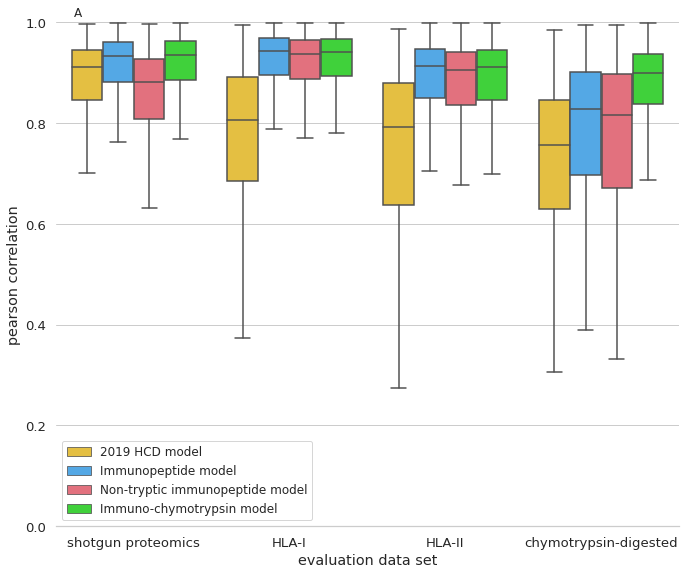

In [27]:
sns.set(style="whitegrid")
sns.set_context("notebook", font_scale=1.2)
g = sns.catplot(
x="evaluation data set",
y="pearson correlation",
hue="Model",
kind="box",
#row="ion",
showfliers=False,
data=performance_evaluation_test, 
palette=thesis_palette,
legend=False,
hue_order=["2019 HCD model", "Immunopeptide model", "Non-tryptic immunopeptide model", "Immuno-chymotrypsin model"],
order=["shotgun proteomics", "HLA-I", "HLA-II", "chymotrypsin-digested"])

g.fig.set_size_inches(10,8)
L = plt.legend(loc='lower left', title='', prop={"size":12})
g.tight_layout()
g.despine(left=True)
g.set(ylim=(0, 1))
g.fig.suptitle('A', x=0.12,y=1, fontsize="small")
plt.savefig("data/Figures/Figure1A.svg")
plt.show()


In [36]:
median_val = performance_evaluation_test.groupby(["Model", "evaluation data set"]).agg({"pearson correlation": "median", "spectral angle": "median"}).reset_index()
median_val

,Model,evaluation data set,pearson correlation,spectral angle
0,2019 HCD model,HLA-I,0.805887,0.649139
1,2019 HCD model,HLA-II,0.791316,0.617992
2,2019 HCD model,chymotrypsin-digested,0.756369,0.561602
3,2019 HCD model,shotgun proteomics,0.910123,0.716115
4,Immuno-chymotrypsin model,HLA-I,0.939815,0.819664
5,Immuno-chymotrypsin model,HLA-II,0.911232,0.758437
6,Immuno-chymotrypsin model,chymotrypsin-digested,0.898770,0.746050
7,Immuno-chymotrypsin model,shotgun proteomics,0.934454,0.785501
8,Immunopeptide model,HLA-I,0.942002,0.822508
9,Immunopeptide model,HLA-II,0.913439,0.760313


In [27]:
performance_evaluation_test["evaluation data set"][performance_evaluation_test.Model == "2019 HCD model"].value_counts()

shotgun proteomics       35212
chymotrypsin-digested    25570
HLA-II                   12745
HLA-I                    12534
Name: evaluation data set, dtype: int64

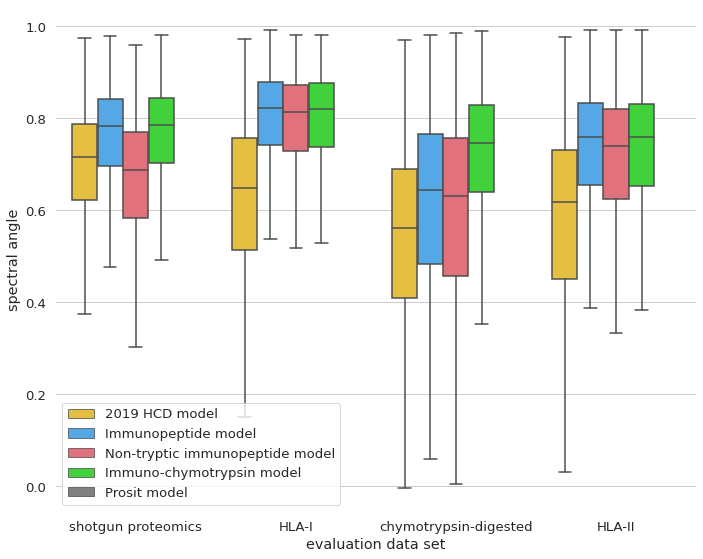

In [28]:
g = sns.catplot(
x="evaluation data set",
y="spectral angle",
hue="Model",
kind="box",
showfliers=False,
data=performance_evaluation_test,
palette=thesis_palette,
legend=False,
hue_order=["2019 HCD model", "Immunopeptide model", "Non-tryptic immunopeptide model", "Immuno-chymotrypsin model", "Prosit model"])

g.fig.set_size_inches(10,8)
L = plt.legend(loc='lower left', title='')
g.tight_layout()
g.despine(left=True, bottom=True)
plt.show()

# Pearson correlation analysis based on charge & length

In [29]:
performance_evaluation_ion = model_predictions.groupby(by=["psmid", "evaluation data set", "Model", "ion"]).agg({"target": list, "prediction":list}).reset_index()
performance_evaluation_ion["psmid"] = performance_evaluation_ion["psmid"].astype(str)
performance_evaluation_ion = performance_evaluation_ion[~(performance_evaluation_ion["psmid"].isin(train_ovr))]

performance_evaluation_ion["pearson correlation"] = performance_evaluation_ion.apply(lambda x: ms2pip_pearson(x.target, x.prediction), axis=1)
performance_evaluation_ion["spectral angle"] = performance_evaluation_ion.apply(lambda x: spectral_angle(x.target, x.prediction), axis=1)

/home/arthur/miniconda3/envs/ms2pip-dev/lib/python3.8/site-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


In [30]:
pxd005231 = pd.read_table("data/evaluation_data/PXD005231/spec_lib_PXD005231.peprec", sep=" ")
pxd005231.head()

,spec_id,peptide,modifications,charge,psm_score,observed_retention_time,Label,Raw file
0,mzspec:PXD005231:20160823_QEh1_LC2_HuPa_SA_HLA...,AAAAAAAAR,-,2.0,102.000,17.164,1.0,20160823_QEh1_LC2_HuPa_SA_HLApI_RA957_1_MG_1
1,mzspec:PXD005231:20160823_QEh1_LC2_HuPa_SA_HLA...,AAAAAAAAR,-,1.0,114.940,14.600,1.0,20160823_QEh1_LC2_HuPa_SA_HLApI_RA957_2_MG_1
2,mzspec:PXD005231:20160902_QEh1_LC2_CHC_SA_HLAp...,AAAAAAAAY,-,1.0,79.935,32.866,1.0,20160902_QEh1_LC2_CHC_SA_HLApI_MD155_3
3,mzspec:PXD005231:20160823_QEh1_LC2_HuPa_SA_HLA...,AAAAAAAER,-,2.0,93.649,15.148,1.0,20160823_QEh1_LC2_HuPa_SA_HLApI_RA957_2_NG_1
4,mzspec:PXD005231:20160823_QEh1_LC2_HuPa_SA_HLA...,AAAAAAATAAR,-,2.0,70.675,23.038,1.0,20160823_QEh1_LC2_HuPa_SA_HLApI_RA957_1_MG_1


In [31]:
pxd005231["peptide length"] = pxd005231.peptide.apply(len)
meta_info = pxd005231.filter(["spec_id", "charge", "peptide length"], axis=1).rename(columns={"spec_id": "psmid"},inplace= False)

In [32]:
performance_evaluation_ion.head()

,psmid,evaluation data set,Model,ion,target,prediction,pearson correlation,spectral angle
0,0,shotgun proteomics,2019 HCD model,b,"[-9.965784, -4.0341287, -5.505439, -8.998842, ...","[-9.400697, -3.2450793, -5.3162956, -7.7925205...",0.982270,0.928376
1,0,shotgun proteomics,2019 HCD model,y,"[-5.7799525, -6.645571, -6.2581835, -6.6281285...","[-5.232238, -5.298642, -5.4611206, -6.4045634,...",0.883807,0.790242
2,0,shotgun proteomics,Immuno-chymotrypsin model,b,"[-9.965784072875977, -4.034128665924072, -5.50...","[-9.736922264099121, -3.8729655742645264, -5.6...",0.972646,0.951268
3,0,shotgun proteomics,Immuno-chymotrypsin model,y,"[-7.009981632232666, -4.3658671379089355, -5.1...","[-7.667525291442871, -4.98584508895874, -5.118...",0.852891,0.788318
4,0,shotgun proteomics,Immunopeptide model,b,"[-9.965784072875977, -4.034128665924072, -5.50...","[-9.901859283447266, -3.257768392562866, -4.89...",0.962964,0.972758


In [33]:
immunopeptide_performance_eval = pd.merge(performance_evaluation_ion.loc[performance_evaluation_ion["evaluation data set"] == "HLA-I"], meta_info, on="psmid", how="inner")

In [34]:
counts = immunopeptide_performance_eval[["charge", "peptide length", "ion"]].groupby(["charge", "ion"]).agg("count").reset_index().rename(columns={"peptide length":"count"})
counts

,charge,ion,count
0,1.0,b,7656
1,1.0,y,7656
2,2.0,b,32572
3,2.0,y,32572
4,3.0,b,9932
5,3.0,y,9932
6,4.0,b,8
7,4.0,y,8


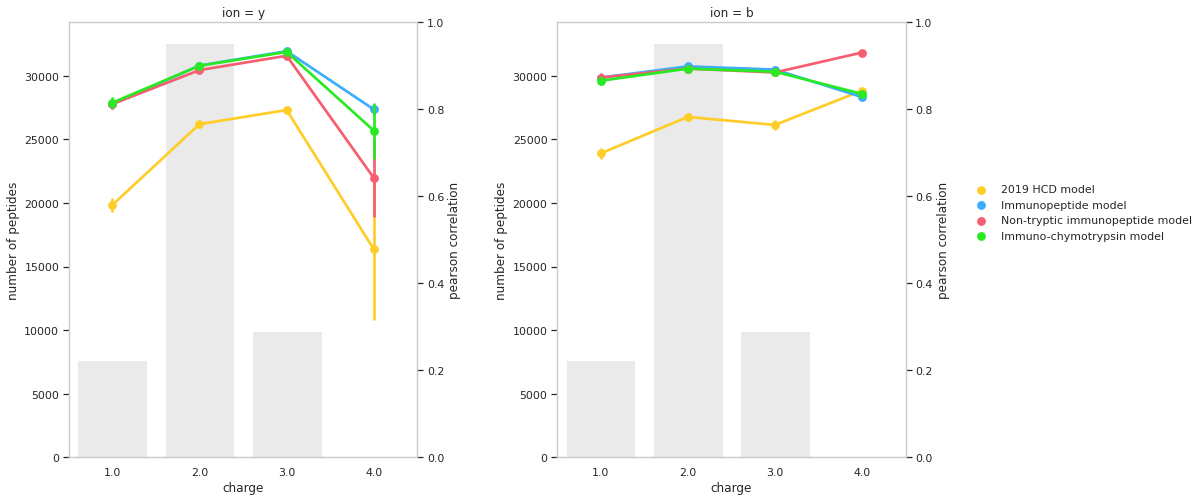

In [35]:
fig = plt.figure()
sns.set(style="whitegrid")

fig.add_subplot(121)

ax = sns.barplot(
x="charge",
y="count",
data=counts[counts.ion == "y"],
color="#EAEAEA")
ax.title.set_text("ion = y")
ax.grid(False)
ax.axes.set_ylabel("number of peptides")
ax2=ax.twinx()
ax2 = sns.pointplot(
x="charge",
y="pearson correlation",
hue="Model",
hue_order=["2019 HCD model", "Immunopeptide model", "Non-tryptic immunopeptide model", "Immuno-chymotrypsin model"],
showfliers=False,
data=immunopeptide_performance_eval.loc[(immunopeptide_performance_eval.ion == "y")],
palette=thesis_palette,
legend= False)
ax2.grid(False)
#ax2.axes.set_ylabel("")
ax2.get_legend().remove()
ax2.axes.set_ylim([0,1])
fig.add_subplot(122)

ax = sns.barplot(
x="charge",
y="count",
data=counts[counts.ion == "b"],
color="#EAEAEA")
ax.axes.set_ylabel("number of peptides")
ax.grid(False)
ax.title.set_text("ion = b")
ax2=ax.twinx()
ax2 = sns.pointplot(
x="charge",
y="pearson correlation",
hue="Model",
hue_order=["2019 HCD model", "Immunopeptide model", "Non-tryptic immunopeptide model", "Immuno-chymotrypsin model"],
showfliers=False,
data=immunopeptide_performance_eval.loc[(immunopeptide_performance_eval.ion == "b")],
palette=thesis_palette,
legend= False,
zorder=3.6)
ax2.grid(False)
ax2.axes.set_ylim([0,1])
ax2.legend(bbox_to_anchor=(1.85, 0.65), frameon=False)

fig.subplots_adjust(wspace=0.4)

fig.set_size_inches(15, 8)
plt.show()

In [36]:
counts = immunopeptide_performance_eval[["charge", "peptide length", "ion"]].groupby(["peptide length", "ion"]).agg("count").reset_index().rename(columns={"charge":"count"})
counts.head()

,peptide length,ion,count
0,8,b,1768
1,8,y,1768
2,9,b,29172
3,9,y,29172
4,10,b,9384


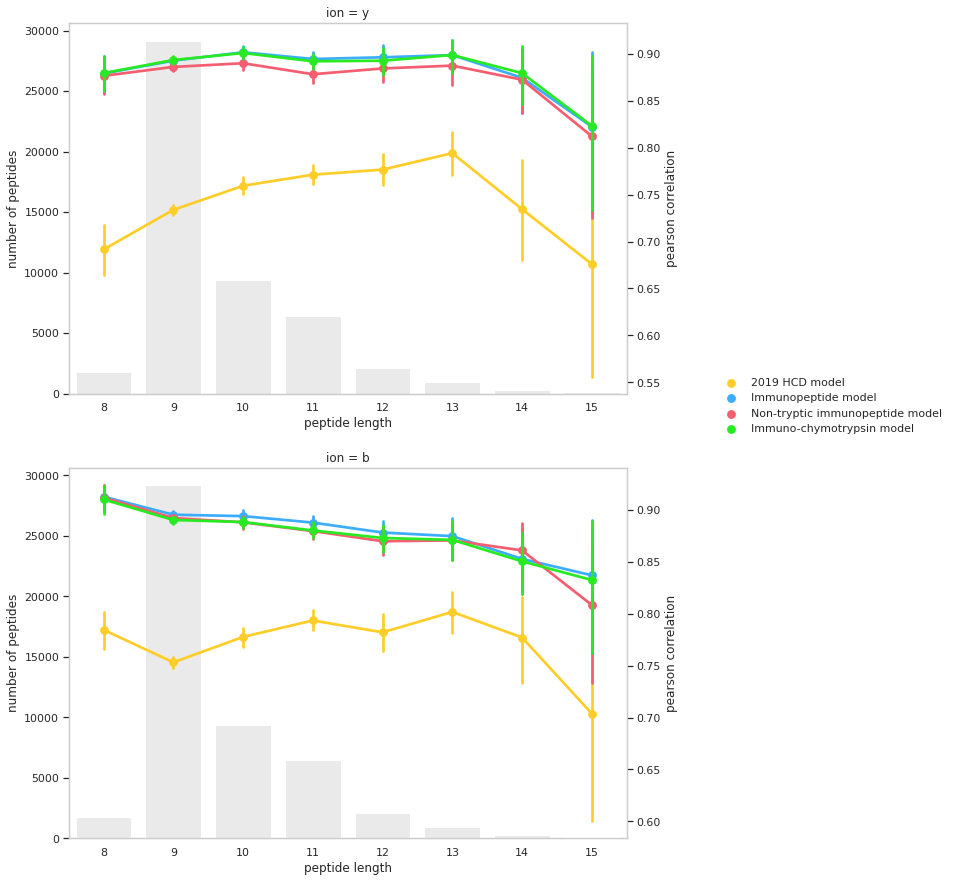

In [37]:
fig = plt.figure()
sns.set(style="whitegrid")

fig.add_subplot(211)

ax = sns.barplot(
x="peptide length",
y="count",
data=counts[counts.ion == "y"],
color="#EAEAEA")
ax.title.set_text("ion = y")
ax.axes.set_ylabel("number of peptides")
ax.grid(False)
#ax.axes.set_ylim([0,14000])
ax2=ax.twinx()
ax2 = sns.pointplot(
x="peptide length",
y="pearson correlation",
hue="Model",
hue_order=["2019 HCD model", "Immunopeptide model", "Non-tryptic immunopeptide model", "Immuno-chymotrypsin model"],
showfliers=False,
data=immunopeptide_performance_eval.loc[(immunopeptide_performance_eval.ion == "y")],
palette=thesis_palette,
legend= False)
ax2.grid(False)
ax2.legend(bbox_to_anchor=(1.15, 0.07), frameon=False)

fig.add_subplot(212)

ax = sns.barplot(
x="peptide length",
y="count",
data=counts[counts.ion == "b"],
color="#EAEAEA",
zorder=2.6)
ax.grid(False)
ax.axes.set_ylabel("number of peptides")
ax.title.set_text("ion = b")
#ax.axes.set_ylim([0,14000])
ax2=ax.twinx()
ax2 = sns.pointplot(
x="peptide length",
y="pearson correlation",
hue="Model",
hue_order=["2019 HCD model", "Immunopeptide model", "Non-tryptic immunopeptide model", "Immuno-chymotrypsin model"],
showfliers=False,
data=immunopeptide_performance_eval.loc[(immunopeptide_performance_eval.ion == "b")],
palette=thesis_palette,
legend= False,
zorder=3.6)
ax2.grid(False)
ax2.get_legend().remove()



fig.set_size_inches(10, 15)
plt.show()

# Chymotrypsin lenght and charge test

In [38]:
chymo_pep = pd.read_table("data/evaluation_data/PXD010154/test_spec_lib_PXD010154.peprec", sep=" ")

In [39]:
chymo_pep["peptide length"] = chymo_pep.peptide.apply(len)
meta_info = chymo_pep.filter(["spec_id", "charge", "peptide length"], axis=1).rename(columns={"spec_id": "psmid"},inplace= False)

In [40]:
chymotrypsin_perf = pd.merge(performance_evaluation_ion.loc[performance_evaluation_ion["evaluation data set"] == "chymotrypsin-digested"], meta_info, on="psmid", how="inner")

In [41]:
counts_charge = chymotrypsin_perf[["charge", "peptide length", "ion"]].groupby(["charge", "ion"]).agg("count").reset_index().rename(columns={"peptide length":"count"})
counts_charge

,charge,ion,count
0,1,b,920
1,1,y,920
2,2,b,22252
3,2,y,22252
4,3,b,48092
5,3,y,48092
6,4,b,20940
7,4,y,20940
8,5,b,7960
9,5,y,7960


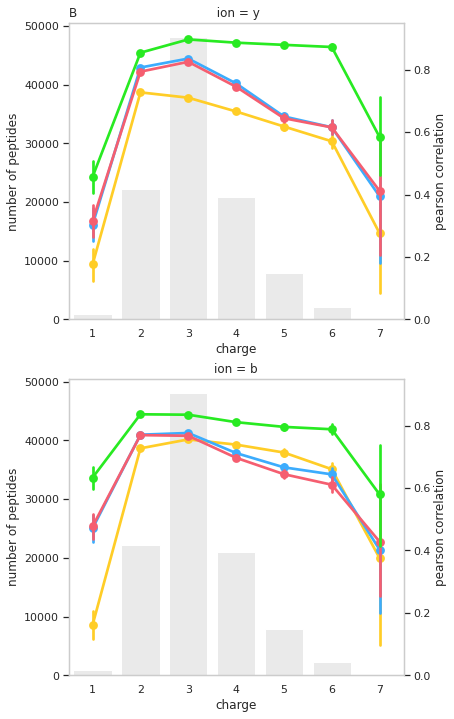

In [42]:
fig = plt.figure()
sns.set(style="whitegrid")

fig.add_subplot(211)

ax = sns.barplot(
x="charge",
y="count",
data=counts_charge[counts_charge.ion == "y"],
color="#EAEAEA")
ax.set_title("B                                    ion = y", loc="left")
ax.axes.set_ylabel("number of peptides")
ax.grid(False)
ax2=ax.twinx()
ax2 = sns.pointplot(
x="charge",
y="pearson correlation",
hue="Model",
hue_order=["2019 HCD model", "Immunopeptide model", "Non-tryptic immunopeptide model", "Immuno-chymotrypsin model"],
showfliers=False,
data=chymotrypsin_perf.loc[(chymotrypsin_perf.ion == "y")],
palette=thesis_palette,
legend= False)
ax2.grid(False)
#ax2.axes.set_ylabel("")
ax2.get_legend().remove()
ax2.axes.set_ylim([0,0.95])
fig.add_subplot(212)

ax = sns.barplot(
x="charge",
y="count",
data=counts_charge[counts_charge.ion == "b"],
color="#EAEAEA")
ax.axes.set_ylabel("number of peptides")
ax.title.set_text("ion = b")
ax.grid(False)
ax2=ax.twinx()
ax2 = sns.pointplot(
x="charge",
y="pearson correlation",
hue="Model",
hue_order=["2019 HCD model", "Immunopeptide model", "Non-tryptic immunopeptide model", "Immuno-chymotrypsin model"],
showfliers=False,
data=chymotrypsin_perf.loc[(chymotrypsin_perf.ion == "b")],
palette=thesis_palette,
legend= False)
ax2.axes.set_ylim([0,0.95])
ax2.get_legend().remove()
#ax2.legend(bbox_to_anchor=(1.15, 0.65), frameon=False)
ax2.grid(False)

# fig.subplots_adjust(wspace=0.4)

fig.set_size_inches(6, 12)
#plt.savefig("data/Figures/FigureS1B.svg")
plt.show()

# Pearson based on length

In [43]:
counts_length = chymotrypsin_perf[["charge", "peptide length", "ion"]].groupby(["peptide length", "ion"]).agg("count").reset_index().rename(columns={"charge":"count"})
counts_length.head()

,peptide length,ion,count
0,7,b,596
1,7,y,596
2,8,b,1324
3,8,y,1324
4,9,b,2200


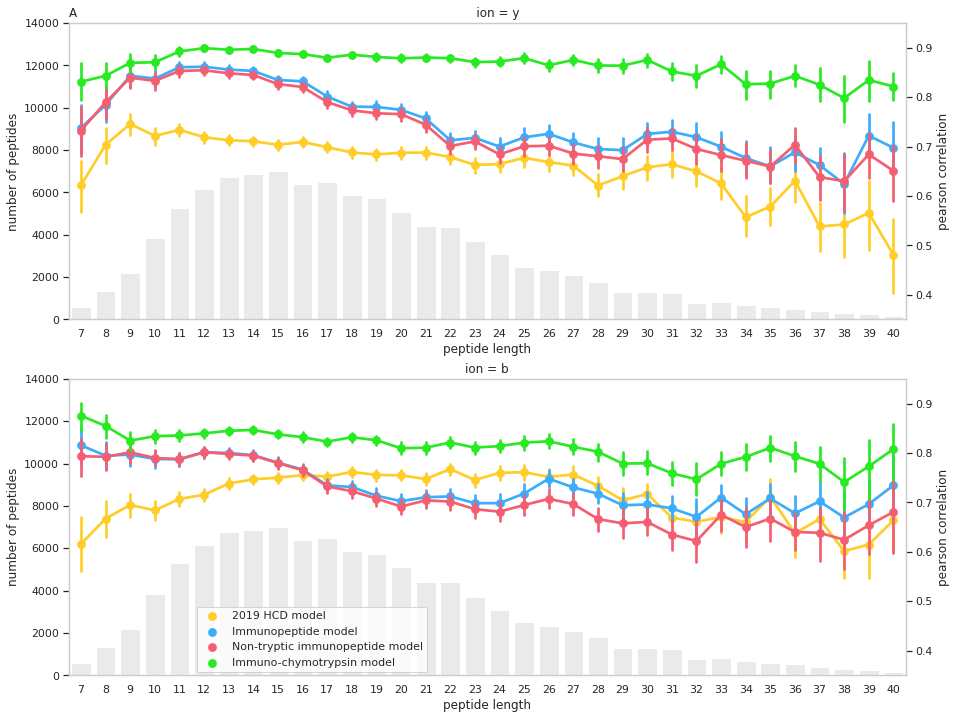

In [44]:
fig = plt.figure()
sns.set(style="whitegrid")

fig.add_subplot(211)

ax = sns.barplot(
x="peptide length",
y="count",
data=counts_length[counts_length.ion == "y"],
color="#EAEAEA")
ax.set_title("A                                                                                                       ion = y", loc="left")
ax.axes.set_ylabel("number of peptides")
ax.axes.set_ylim([0,14000])
ax.grid(False)
ax2=ax.twinx()
ax2 = sns.pointplot(
x="peptide length",
y="pearson correlation",
hue="Model",
hue_order=["2019 HCD model", "Immunopeptide model", "Non-tryptic immunopeptide model", "Immuno-chymotrypsin model"],
showfliers=False,
data=chymotrypsin_perf.loc[(chymotrypsin_perf["peptide length"] <= 40) & (chymotrypsin_perf.ion == "y")],
palette=thesis_palette,
legend= False)
ax2.grid(False)
ax2.axes.set_ylim([0.35,0.95])
#ax2.legend(bbox_to_anchor=(.40, 0.30), frameon=True)
ax2.get_legend().remove()

fig.add_subplot(212)

ax = sns.barplot(
x="peptide length",
y="count",
data=counts_length[counts_length.ion == "b"],
color="#EAEAEA",
zorder=2.6)
ax.grid(False)
ax.axes.set_ylabel("number of peptides")
ax.title.set_text("ion = b")
ax.axes.set_ylim([0,14000])
ax2=ax.twinx()
ax2 = sns.pointplot(
x="peptide length",
y="pearson correlation",
hue="Model",
hue_order=["2019 HCD model", "Immunopeptide model", "Non-tryptic immunopeptide model", "Immuno-chymotrypsin model"],
showfliers=False,
data=chymotrypsin_perf.loc[(chymotrypsin_perf["peptide length"] <= 40) & (chymotrypsin_perf.ion == "b")],
palette=thesis_palette,
legend= True,
zorder=3.6)
ax2.grid(False)
ax2.axes.set_ylim([0.35,0.95])
ax2.legend(bbox_to_anchor=(.435, 0.25), frameon=True)


fig.set_size_inches(15, 12)
#plt.savefig("data/Figures/FigureS1A.svg")
plt.show()

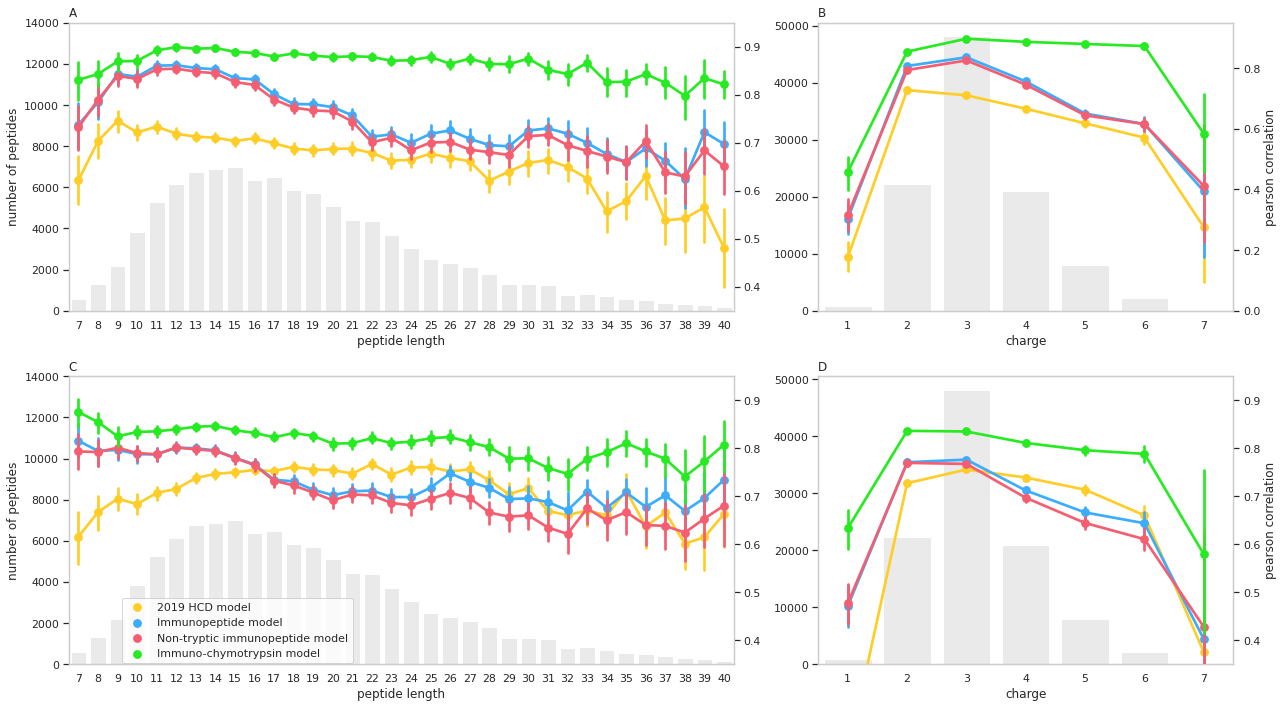

In [45]:
fig = plt.figure(figsize=(18,10))
sns.set(style="whitegrid")

ax = plt.subplot2grid((2,5),(0,0), colspan=3, fig=fig)

sns.barplot(
x="peptide length",
y="count",
data=counts_length[counts_length.ion == "y"],
color="#EAEAEA",
ax=ax)
ax.set_title("A", loc="left")
ax.axes.set_ylabel("number of peptides")
ax.axes.set_ylim([0,14000])
ax.grid(False)
ax2=ax.twinx()
sns.pointplot(
x="peptide length",
y="pearson correlation",
hue="Model",
hue_order=["2019 HCD model", "Immunopeptide model", "Non-tryptic immunopeptide model", "Immuno-chymotrypsin model"],
showfliers=False,
data=chymotrypsin_perf.loc[(chymotrypsin_perf["peptide length"] <= 40) & (chymotrypsin_perf.ion == "y")],
palette=thesis_palette,
legend= False,
ax=ax2)
ax2.grid(False)
ax2.axes.set_ylim([0.35,0.95])
ax2.set_ylabel("")
ax2.get_legend().remove()

ax = plt.subplot2grid((2,5),(1,0), colspan=3, fig=fig)

sns.barplot(
x="peptide length",
y="count",
data=counts_length[counts_length.ion == "b"],
color="#EAEAEA",
ax=ax)
ax.grid(False)
ax.axes.set_ylabel("number of peptides")
ax.set_title("C", loc="left")
ax.axes.set_ylim([0,14000])
ax2=ax.twinx()
sns.pointplot(
x="peptide length",
y="pearson correlation",
hue="Model",
hue_order=["2019 HCD model", "Immunopeptide model", "Non-tryptic immunopeptide model", "Immuno-chymotrypsin model"],
showfliers=False,
data=chymotrypsin_perf.loc[(chymotrypsin_perf["peptide length"] <= 40) & (chymotrypsin_perf.ion == "b")],
palette=thesis_palette,
legend= True,
ax=ax2)
ax2.grid(False)
ax2.set_ylabel("")

ax2.axes.set_ylim([0.35,0.95])
ax2.legend(bbox_to_anchor=(.435, 0.25), frameon=True)

ax = plt.subplot2grid((2,5),(0,3), colspan=2, fig=fig)

sns.barplot(
x="charge",
y="count",
data=counts_charge[counts_charge.ion == "y"],
color="#EAEAEA",
ax=ax)
ax.set_title("B", loc="left")
ax.grid(False)
ax.set_ylabel("")
ax2 = ax.twinx()
sns.pointplot(
x="charge",
y="pearson correlation",
hue="Model",
hue_order=["2019 HCD model", "Immunopeptide model", "Non-tryptic immunopeptide model", "Immuno-chymotrypsin model"],
showfliers=False,
data=chymotrypsin_perf.loc[(chymotrypsin_perf.ion == "y")],
palette=thesis_palette,
legend= False,
ax=ax2)
ax2.grid(False)
ax2.axes.set_ylim([0.35,0.95])
ax2.get_legend().remove()
ax2.axes.set_ylim([0,0.95])

ax = plt.subplot2grid((2,5),(1,3), colspan=2, fig=fig)

sns.barplot(
x="charge",
y="count",
data=counts_charge[counts_charge.ion == "b"],
color="#EAEAEA",
ax=ax)
ax.set_title("D", loc="left")
ax.set_ylabel("")
ax.grid(False)
ax2=ax.twinx()
sns.pointplot(
x="charge",
y="pearson correlation",
hue="Model",
hue_order=["2019 HCD model", "Immunopeptide model", "Non-tryptic immunopeptide model", "Immuno-chymotrypsin model"],
showfliers=False,
data=chymotrypsin_perf.loc[(chymotrypsin_perf.ion == "b")],
palette=thesis_palette,
legend= False,
ax=ax2)
ax2.axes.set_ylim([0.35,0.95])
ax2.get_legend().remove()
ax2.grid(False)

# fig.subplots_adjust(wspace=0.4)
fig.tight_layout()
fig.savefig("data/Figures/FigureS1.svg")
